In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    test, 
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-14 15:38:54.490913: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 15:38:54.501022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 15:38:54.847920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 15:38:54.850641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 15:38:55.942215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)

# Choose SNPs to project on n dimensions

In [3]:

path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_projected/"
nr_of_projected_dimensions = 3
project_on_dimensions(path_input, path_output, nr_of_projected_dimensions)


# Observe raw dimensions

In [4]:
path_input = f"{CONFIG['PATH_data']}/04_projected/snp_ids.pkl"
pd.read_pickle(path_input)

,pval,betas,snp_rs,-logp,dim
139,1.770881e-82,-10.566159,rs10803434_A,81.751811,1
689,9.291462e-80,-10.435182,rs11802371_G,79.031916,1
18,1.158522e-67,9.686547,rs12743883_G,66.936096,1
321,1.249945e-65,-9.512141,rs4424509_G,64.903109,1
0,2.957019e-65,9.584452,rs3928804_T,64.529146,1
...,...,...,...,...,...
84,8.830340e-01,-0.042491,rs5769852_C,0.054023,3
7,8.906630e-01,-0.039375,rs1894252_A,0.050287,3
103,9.102854e-01,0.035420,rs1974458_G,0.040822,3
77,9.535662e-01,0.016828,rs135972_G,0.020649,3


In [7]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    

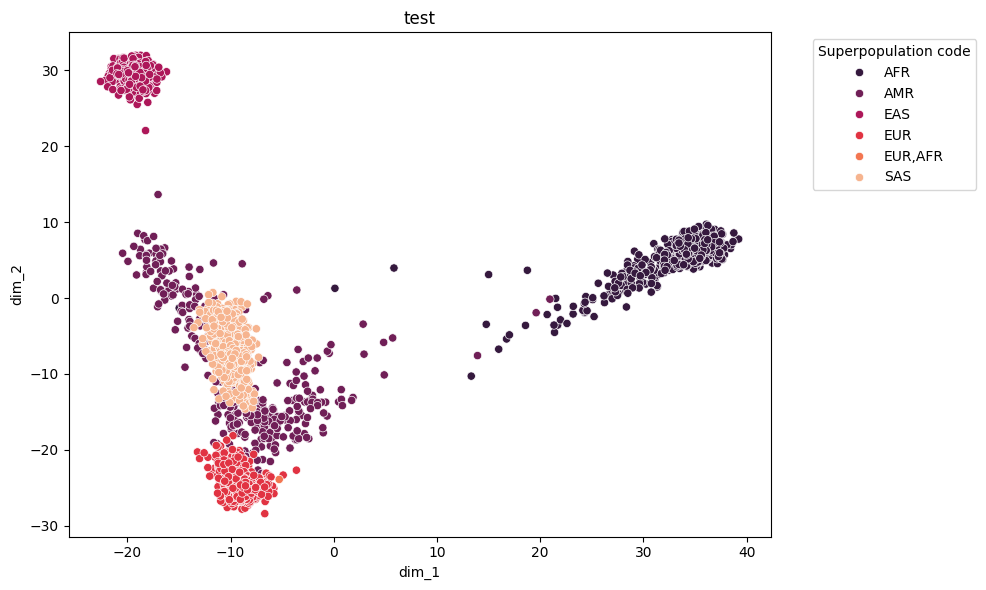

In [8]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')

In [9]:
labels = silhouette_score_clusters(merged_df, ['dim_1', 'dim_2', 'dim_3'], plot=False)

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_pro

The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
merged_df['clusters'] = labels

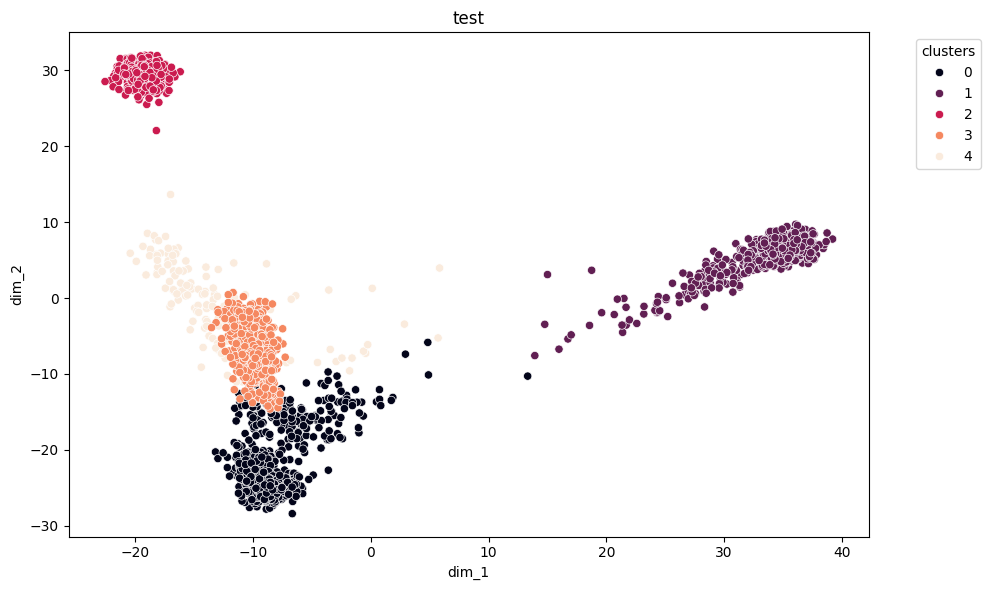

In [11]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')

In [12]:
merged_df.to_pickle(f"{CONFIG['PATH_data']}/04_projected/samples_with_clusters.pkl")

In [13]:

path_input  = f"{CONFIG['PATH_data']}/03_macro_similar_AF"
for cluster in list(merged_df['clusters'].unique()):
    cluster_df = merged_df[merged_df['clusters'] == cluster]
    for chrom in [f for f in os.listdir(path_input) if f.startswith('chrom')]:
        path_chrom = f"{path_input}/{chrom}"
        for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')]:
            path_chunk = f"{path_chrom}/{chunk}"
            chunk_df = pd.read_pickle(path_chunk)
            chunk_df['IID'] = ids['IID']
            merged = pd.merge(cluster_df[['IID']], chunk_df, on='IID')
            merged.drop('IID', axis=1, inplace=True)
            path_output = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/pop_{cluster}/{chrom}"
            os.makedirs(path_output, exist_ok=True)
            merged.to_pickle(f"{path_output}/{chunk}")

In [30]:
# iteration 1

In [2]:

path_input = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/"
path_output = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_input_pop = f"{path_input}/{pop}"
    path_output_pop = f"{path_output}/{pop}"
    nr_of_projected_dimensions = 3
    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)

NameError: name 'merged_df' is not defined

In [8]:
PC_dim

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.494515,3.460413,0.484565,-5.615841,-5.255465,1.063959,-5.159212,0.332341,-2.900008,2.968997
1,-6.432453,-1.470604,3.512052,-4.033445,7.014998,3.084912,-3.510527,2.272023,4.466060,2.829362
2,-1.566904,2.607386,-0.461227,0.095508,5.685674,-2.971195,3.533615,7.382368,-12.446222,8.670536
3,0.263772,1.243824,1.121846,-2.882928,1.622300,4.449209,-5.893241,3.192020,-6.041383,-7.127180
4,-4.968583,0.178256,5.971543,-4.164557,-0.310140,3.871466,4.070541,-2.264416,2.693405,0.710953
...,...,...,...,...,...,...,...,...,...,...
484,5.669657,-4.805616,-0.551065,1.568589,2.831690,5.105920,1.235247,4.772687,-3.652232,-4.740071
485,0.241317,-4.278318,0.278800,2.314636,-0.555474,0.993031,0.686816,5.053272,3.946775,3.562971
486,1.524480,1.489637,0.956803,0.724138,0.278085,-0.150252,2.910190,3.864437,6.036729,4.214508
487,-1.146712,-3.621960,-0.771281,2.048687,-3.299539,-2.975529,0.959766,-5.154944,1.258850,0.463792


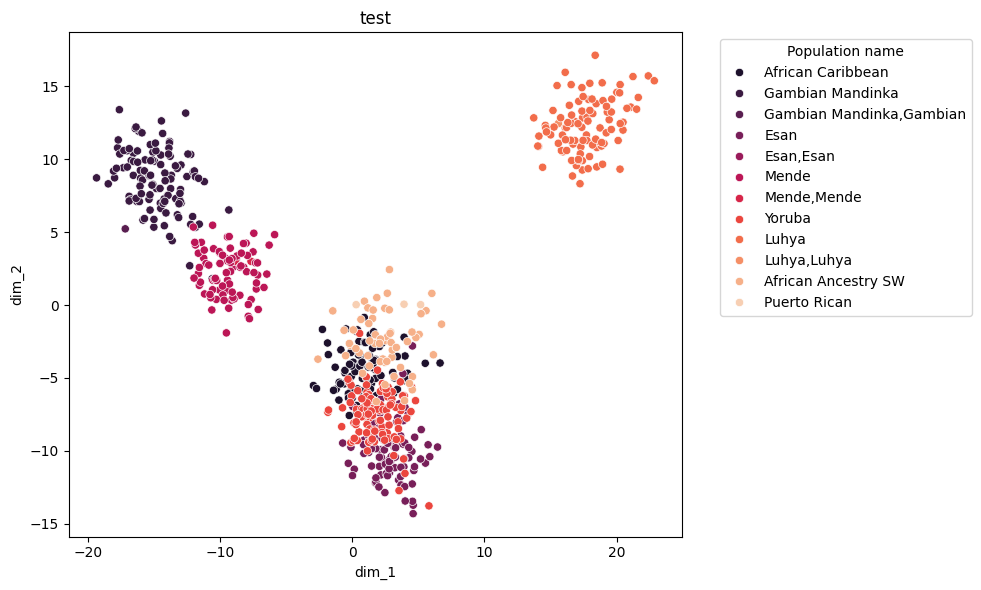

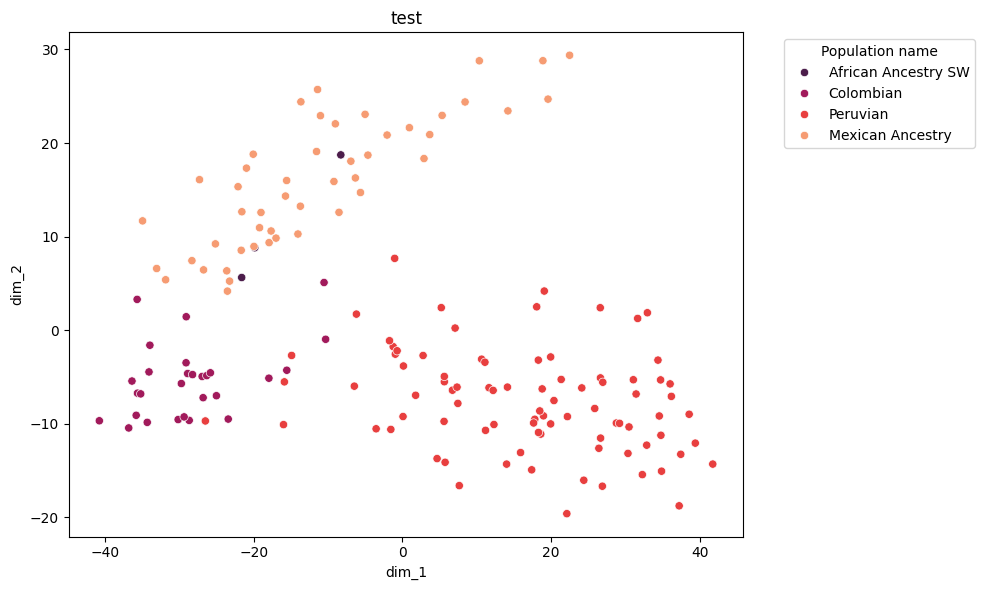

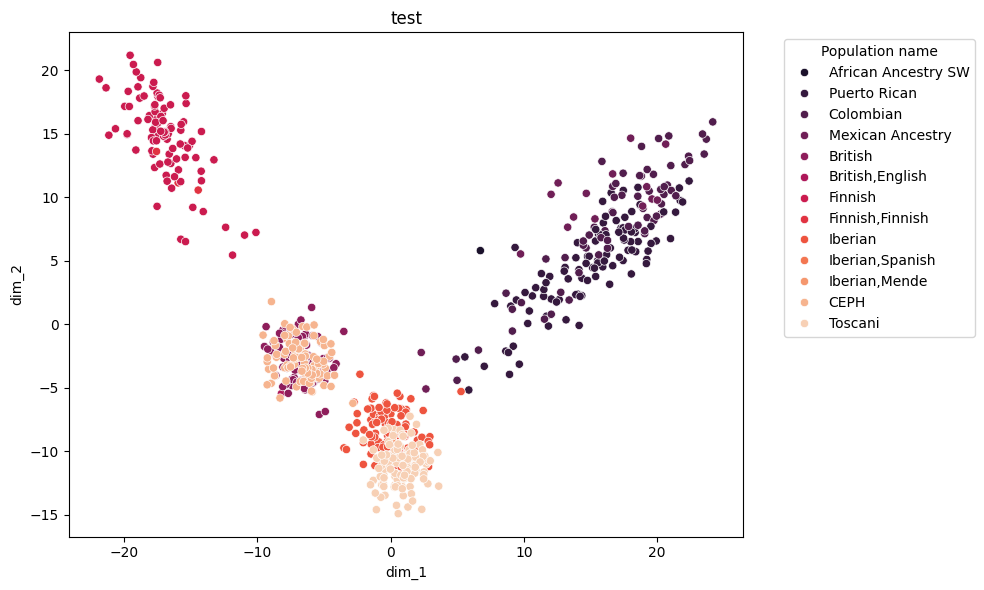

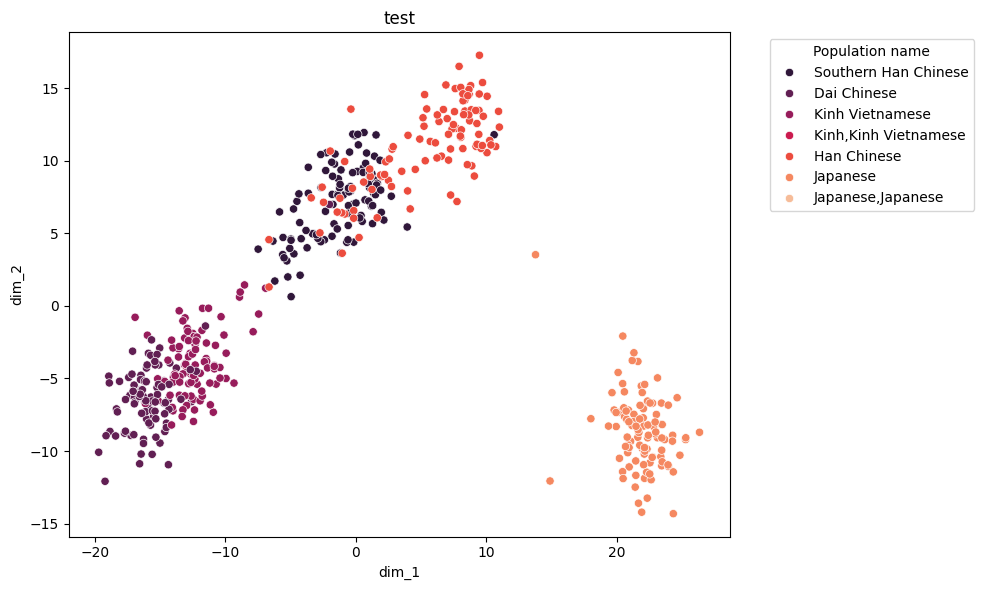

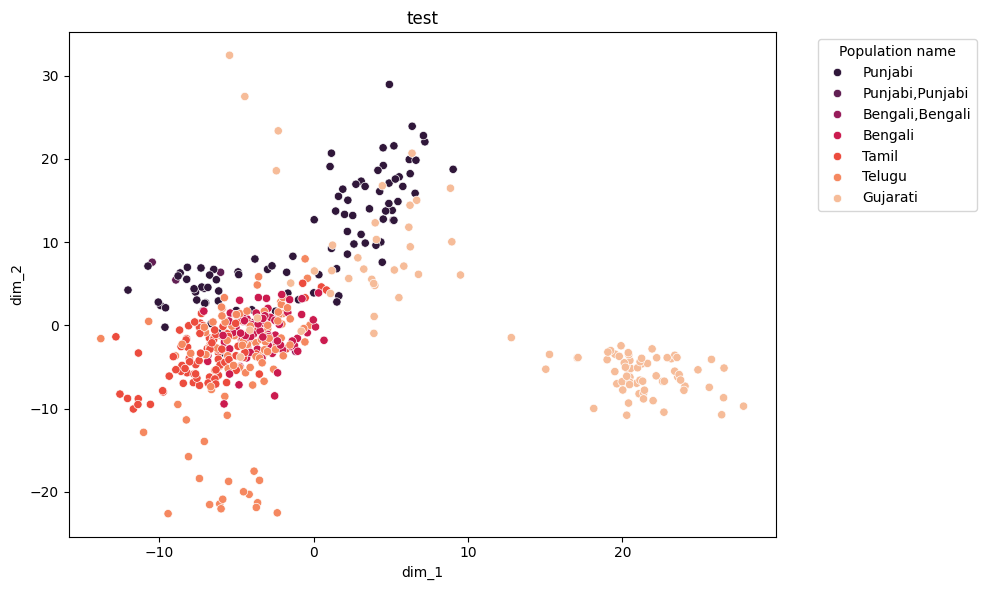

In [12]:
merged_df = pd.read_pickle(f"{CONFIG['PATH_data']}/04_projected/samples_with_clusters.pkl")
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:
    pop = int(pop.split('_')[1])
    temp_samples = merged_df[merged_df['clusters'] == pop].copy()
    path_pop = f"{path_input}/pop_{pop}"
    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]
    for dim in dims:
        path_dim = f"{path_pop}/{dim}"
        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
        path_PC = f"{path_dim}/{PCs}"
        PC_dim = pd.read_pickle(path_PC)
        temp_samples[dim] = list(PC_dim['PC1'])
    make_population_plot(temp_samples, 'dim_1', 'dim_2', 'Population name', 'test', palette = 'rocket')

In [10]:
temp_samples


,FID,IID,PAT,MAT,SEX,PHENOTYPE,Sample name,Sex,Population code,Population name,Superpopulation code,Superpopulation name,dim_1,dim_2,dim_3,clusters
2015,SAS,HG01583,0,0,1,-9,HG01583,male,PJL,Punjabi,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2016,SAS,HG01586,0,0,1,-9,HG01586,male,PJL,Punjabi,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2017,SAS,HG01589,0,0,1,-9,HG01589,male,PJL,Punjabi,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2018,SAS,HG01593,0,0,2,-9,HG01593,female,PJL,Punjabi,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2019,SAS,HG02490,0,0,1,-9,HG02490,male,PJL,Punjabi,SAS,South Asian Ancestry,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,SAS,NA21137,0,0,2,-9,NA21137,female,GIH,Gujarati,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2500,SAS,NA21141,0,0,2,-9,NA21141,female,GIH,Gujarati,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2501,SAS,NA21142,0,0,2,-9,NA21142,female,GIH,Gujarati,SAS,South Asian Ancestry,NaN,NaN,NaN,3
2502,SAS,NA21143,0,0,2,-9,NA21143,female,GIH,Gujarati,SAS,South Asian Ancestry,NaN,NaN,NaN,3


In [ ]:
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/02_usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    

In [ ]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_output = f"{CONFIG['PATH_data']}/05_macro_per_pop/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    chroms = [f for f in os.listdir(path_dim) if f.startswith("chrom")]
    for chrom in chroms:
        path_chrom = f"{path_dim}/{chrom}"
        for chunk in os.listdir(path_chrom):
            path_chunk = f"{path_chrom}/{chunk}"
            chunk_df = pd.read_pickle(path_chunk)
            chunk_df['clusters'] = labels
            for pop in chunk_df['clusters'].unique():
                pop_df = chunk_df[chunk_df['clusters'] == pop]
                pop_df = pop_df.drop(columns=['clusters'])
                os.makedirs(f"{path_output}/{dim}/pop_{pop}/{chrom}/", exist_ok=True)
                pop_df.to_pickle(f"{path_output}/{dim}/pop_{pop}/{chrom}/{chunk}")
            
    	

In [2]:
nr_of_projected_dimensions = 3

path_input = f"{CONFIG['PATH_data']}/05_macro_per_pop/"
path_output = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    path_output_dim = f"{path_output}/{dim}"
    for pop in os.listdir(path_dim):
        path_pop = f"{path_dim}/{pop}"
        path_output_pop = f"{path_output_dim}/{pop}"
        project_on_dimensions(path_pop, path_output_pop, nr_of_projected_dimensions)
        

/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']
/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']
/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

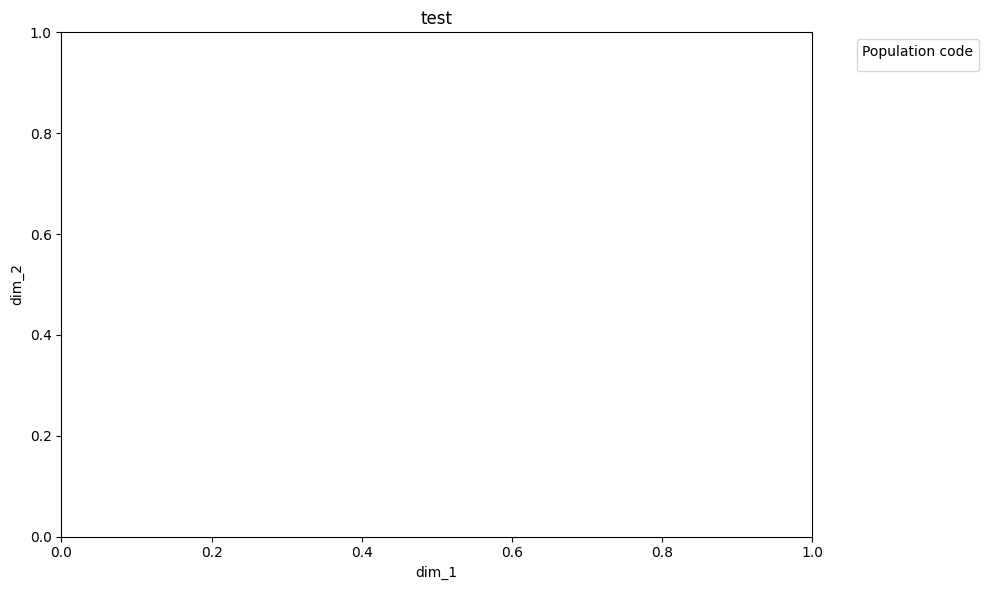

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


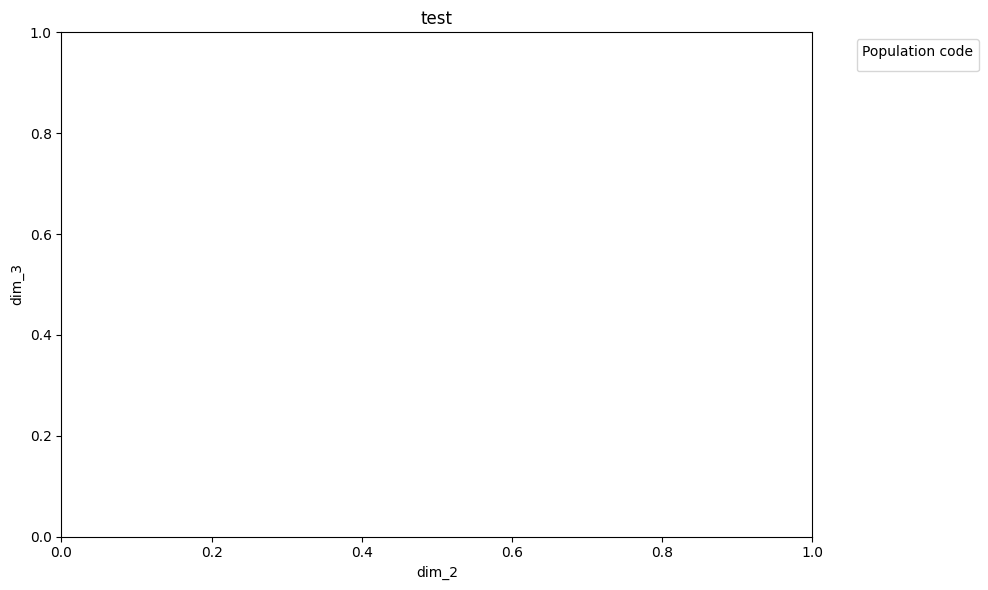

/tmp/ipykernel_25599/1815285419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans[pop_dim] = PC_dim['PC1']


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/GTM_data2/06_projected_per_pop//dim_1/pop_4/dim_2/global_PCs.pkl'

In [10]:

path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for pop in os.listdir(path_dim):
        temp_humans = merged_df[merged_df['clusters'] == int(pop.split('_')[1])]	
        path_pop = f"{path_dim}/{pop}"
        for pop_dim in [f for f in os.listdir(path_pop) if f.startswith("dim")]:
            path_PCs = f"{path_pop}/{pop_dim}/global_PCs.pkl"
            PC_dim = pd.read_pickle(path_PCs)
            temp_humans[pop_dim] = PC_dim['PC1']
        make_population_plot(temp_humans, 'dim_1', 'dim_2', 'Population code', 'test', palette = 'rocket')
        make_population_plot(temp_humans, 'dim_2', 'dim_3', 'Population code', 'test', palette = 'rocket')
        

In [11]:
"""
N_PCs = 2
N_snps_block = 100

path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_output = f"{CONFIG['PATH_data']}/05_ld_blocks/"

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        for file in os.listdir(path_input_chrom):
            filename = file.split(".pkl")[0]
            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)
"""

'\nN_PCs = 2\nN_snps_block = 100\n\npath_input = f"{CONFIG[\'PATH_data\']}/04_projected/"\npath_output = f"{CONFIG[\'PATH_data\']}/05_ld_blocks/"\n\nfor dim in os.listdir(path_input):\n    path_dim = f"{path_input}/{dim}"\n    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:\n        path_input_chrom = f"{path_dim}/{chrom}/"\n        path_output_chrom = f"{path_output}/{dim}/{chrom}/"\n        os.makedirs(path_output_chrom, exist_ok=True)\n        for file in os.listdir(path_input_chrom):\n            filename = file.split(".pkl")[0]\n            segmenter(path_input_chrom, path_output_chrom, filename , N_PCs, N_snps_block)\n'

In [39]:

"""
path_input = f"{CONFIG['PATH_data']}/05_LD_blocks/"
path_output = f"{CONFIG['PATH_data']}/06_esti_mafs/"
n_components = 4

for dim in os.listdir(path_input):
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output}/{dim}/{chrom}/"
        blocks = [f for f in os.listdir(path_input_chrom) if f.startswith("block")]
        for block in blocks:
            linear_abyss(path_input_chrom, block, path_output_chrom, n_components, p2=True, twopq=True, q2=True)
"""

In [40]:
"""
# Align all the dataframes
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    for chrom in [f for f in os.listdir(path_dim) if f.startswith("chrom")]:
        path_input_chrom = f"{path_dim}/{chrom}"
        blocks = [f for f in os.listdir(f"{path_input_chrom}/q2") if f.startswith("block")]
        for block in blocks:
            path_q2 = f"{path_input_chrom}/q2/{block}"
            path_2pq = f"{path_input_chrom}/2pq/{block}"
            path_p2 = f"{path_input_chrom}/p2/{block}"
            minaf = pd.read_pickle(path_q2)
            hetaf = pd.read_pickle(path_2pq)
            majaf = pd.read_pickle(path_p2)
            # Example usage with your loaded DataFrames
            minaf, hetaf, majaf = align_dataframes(minaf, hetaf, majaf)
            minaf.to_pickle(f"{path_input_chrom}/q2/{block}")
            hetaf.to_pickle(f"{path_input_chrom}/2pq/{block}")
            majaf.to_pickle(f"{path_input_chrom}/p2/{block}")
"""


In [ ]:
"""
path_input = f"{CONFIG['PATH_data']}/06_esti_mafs/"
path_output = f"{CONFIG['PATH_data']}/07_esti_Fst/"

dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    path_output_dim = f"{path_output}/{dim}"
    chroms = [f for f in os.listdir(path_dim) if f.startswith("chrom")]
    for chrom in chroms:
        path_input_chrom = f"{path_dim}/{chrom}/"
        path_output_chrom = f"{path_output_dim}/{chrom}/"
        os.makedirs(path_output_chrom, exist_ok=True)
        files = [f for f in os.listdir(f"{path_input_chrom}/p2/") if f.startswith("block")]
        for file in files:
            make_fst(path_input_chrom, file, path_output_chrom)
"""

In [2]:


path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    os.makedirs(path_dim, exist_ok=True)
    make_global_fst(path_dim, path_dim)


In [10]:
path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    
    reducer = umap.UMAP(n_components=1, metric='precomputed', random_state=42)
    embedding = reducer.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/pytho

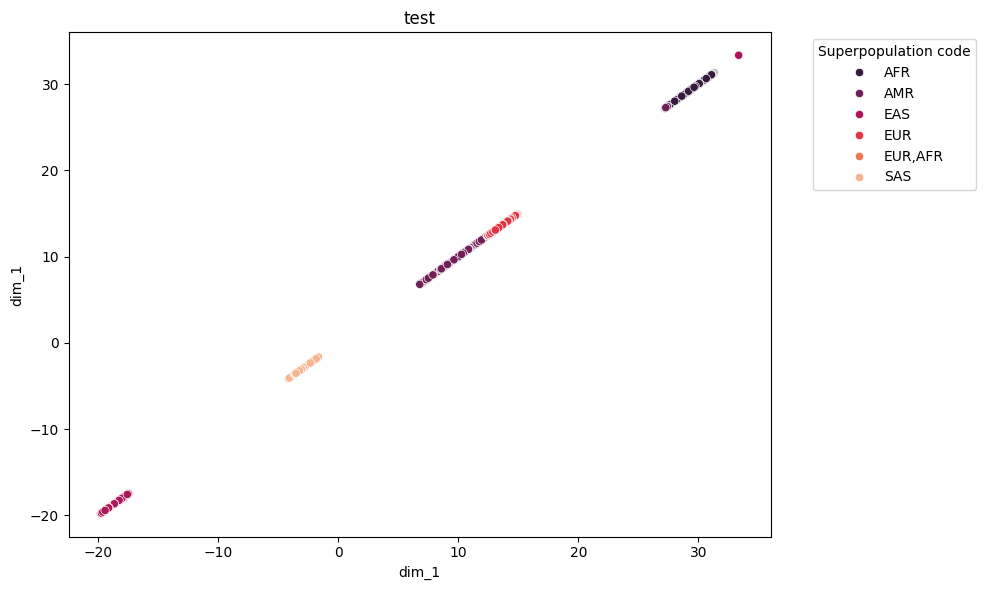

In [11]:
make_population_plot(merged_df, 'dim_1', 'dim_1', 'Superpopulation code', 'test', palette = 'rocket')


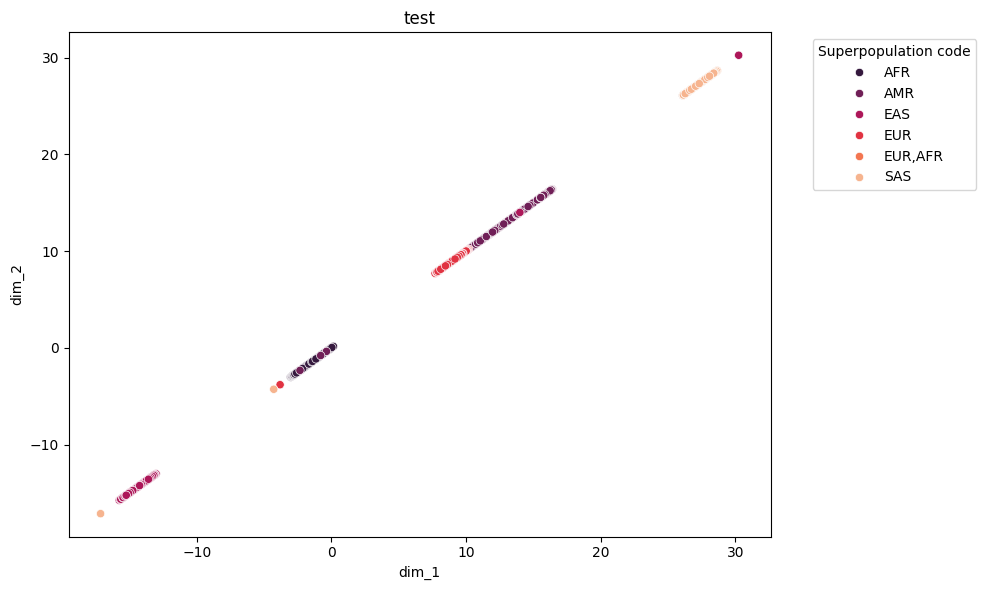

In [6]:
from sklearn.manifold import TSNE

path_afs = f"{CONFIG['PATH_data']}/usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/usefull/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")

path_input = f"{CONFIG['PATH_data']}/07_esti_Fst/"
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    Fst_global = pd.read_pickle(f"{path_dim}/global_Fst.pkl")
    # Compute 1D t-SNE embedding with the correct init parameter
    tsne = TSNE(n_components=1, metric='precomputed', init='random', random_state=42)
    embeddings = tsne.fit_transform(Fst_global)
    merged_df[[f"{dim}"]] = embedding

make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation code', 'test', palette = 'rocket')


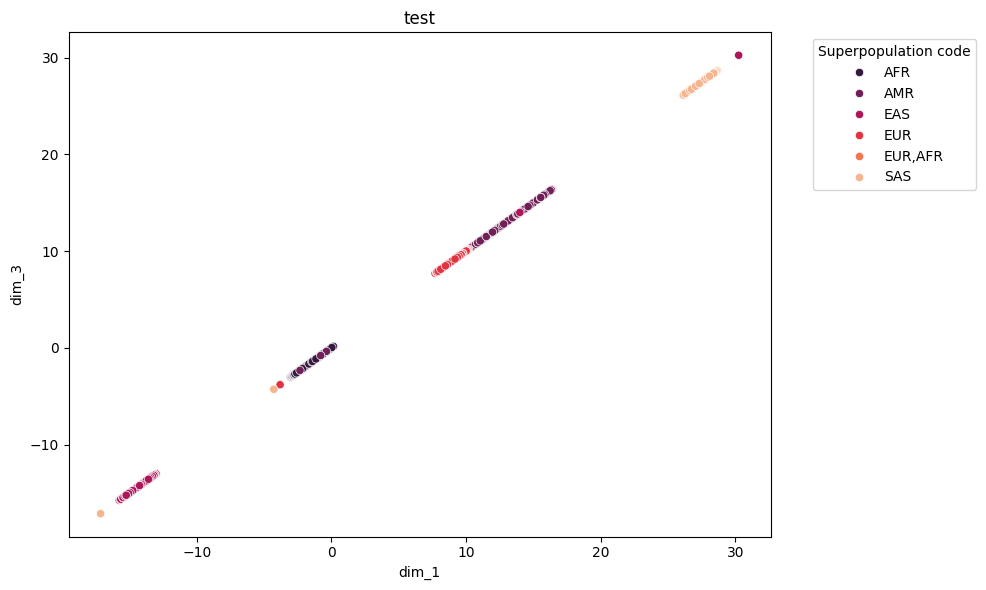

In [8]:
make_population_plot(merged_df, 'dim_1', 'dim_3', 'Superpopulation code', 'test', palette = 'rocket')
